In [1]:
import pandas as pd
import os
from functools import reduce

import numpy as np
import scipy.stats as st

import time

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

from mne.viz import plot_topomap
from sklearn.decomposition import FastICA


from IPython.display import clear_output

from scipy.signal import butter, filtfilt, iirnotch, lombscargle, resample, ellip
from scipy import signal

## Custom pdf

In [2]:
import numpy as np


def ass(tail_weigth = .05):
    if np.random.rand() > tail_weigth:
        return np.random.rand()*60
    x = abs(np.random.normal())
    while st.norm.sf(x)>tail_weigth:
        x = abs(np.random.normal())
    return 60 + x - st.norm.ppf(1-tail_weigth)

def extract_from_ass(num_samples, tail_weigth = .05):
    return np.array([ass(tail_weigth) for _ in range(num_samples)])

In [3]:
X = extract_from_ass(100000)
len(np.where(X>60)[0])

5035

## CSV reading function for pureEEG

In [4]:
def read_EEG_csv(title):
    db2 = pd.read_csv(title + '.md.csv', skiprows=[0])
    header = {}
    f = open(title + '.md.csv', 'r')
    for h in f.readline().split(','):
        hh = h.split(':')
        header[hh[0].replace(' ', '')] = hh[1].split()
    f.close()
    db2.columns = header['labels']
    db2.TIME_STAMP_ms += db2.TIME_STAMP_s*1000
    
    db1 = pd.read_csv(title + '.csv', skiprows=[0])
    header = {}
    f = open(title + '.csv', 'r')
    for h in f.readline().split(','):
        hh = h.split(':')
        header[hh[0].replace(' ', '')] = hh[1].split()
    f.close()
    db1.columns = header['labels']
    db1.TIME_STAMP_ms += db1.TIME_STAMP_s*1000
    
    database = pd.merge(db1, db2, on = 'TIME_STAMP_ms', how = 'left', suffixes=['_eeg', '_md'])
    header['labels'] = list(database.columns)
    
    return database.ffill(), header

In [5]:
path = os.getcwd() + '\\supervised data\\'
f = path + 'Tom-1-22.06.17-17.25.35'
database, header =  read_EEG_csv(f)

In [6]:
print(database.head(100))

    COUNTER  INTERPOLATED          AF3           F7           F3          FC5  \
0     116.0           0.0  4021.538330  3950.256348  4116.922852  4103.076660   
1     117.0           0.0  4023.076904  3950.256348  4114.871582  4107.692383   
2     118.0           0.0  4017.948730  3949.230713  4109.743652  4102.563965   
3     119.0           0.0  4021.538330  3957.435791  4111.281738  4098.974121   
4     120.0           0.0  4026.153809  3959.487061  4109.743652  4100.000000   
5     121.0           0.0  4025.128174  3956.923096  4111.281738  4102.051270   
6     122.0           0.0  4032.307617  3964.102539  4123.589844  4107.179199   
7     123.0           0.0  4042.563965  3970.769043  4126.153809  4109.743652   
8     124.0           0.0  4048.205078  3977.435791  4123.589844  4112.820312   
9     125.0           0.0  4053.333252  3977.948730  4130.256348  4110.256348   
10    126.0           0.0  4060.000000  3974.871582  4137.436035  4109.743652   
11    127.0           0.0  4

In [7]:
print(header)

{'chan': ['40'], 'subject': ['Tom'], 'labels': ['COUNTER', 'INTERPOLATED', 'AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4', 'RAW_CQ', 'GYROX_eeg', 'GYROY_eeg', 'MARKER', 'MARKER_HARDWARE', 'SYNC', 'TIME_STAMP_s_eeg', 'TIME_STAMP_ms', 'CQ_AF3', 'CQ_F7', 'CQ_F3', 'CQ_FC5', 'CQ_T7', 'CQ_P7', 'CQ_O1', 'CQ_O2', 'CQ_P8', 'CQ_T8', 'CQ_FC6', 'CQ_F4', 'CQ_F8', 'CQ_AF4', 'CQ_CMS', 'CQ_DRL', 'COUNTER_MEMS', 'GYROX_md', 'GYROY_md', 'GYROZ', 'ACCX', 'ACCY', 'ACCZ', 'MAGX', 'MAGY', 'MAGZ', 'TIME_STAMP_s_md'], 'recorded': ['22.06.17', '17.25.35'], 'units': ['emotiv'], 'title': ['1'], 'sampling': ['128']}


## Filtering

In [52]:
wave = database.loc[:,'AF3':'AF4'].values
print(wave.shape)

time = np.asarray(database['TIME_STAMP_ms'])
time = time
times = (time[-1] - time[0]) /1000.0
print(times/60)
print(wave.shape[0]/128)

time = time /1000.0
time = list(np.floor(time))
print(time.count(23367))

(209407, 14)
27.6019401711
1635.9921875
127


In [53]:
print(wave[50])

[ 4073.84594727  4058.46142578  4117.43603516  4109.23046875  4152.30761719
  4140.51269531  4163.07666016  4129.23046875  4138.46142578  4136.41015625
  4104.10253906  4098.97412109  4019.48706055  4063.0769043 ]


In [80]:
fs = 128
f0 = 43.0/6.2
f1 = 1/6.2
Q = 15.0
w0 = f0/(fs/2)
w1 = f1/(fs/2)

# b, a = ellip(2, 3, 100.0, w1, "highpass")
d, c = butter(4, w1, "highpass")
f, e = butter(4, w0)
# f, e = iirnotch(w0, Q)

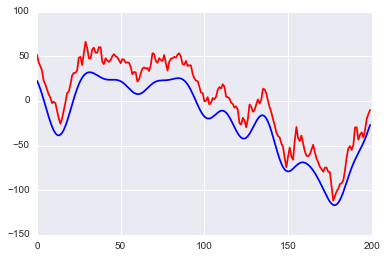

In [81]:
wave2 = np.copy(wave)
for i in range(wave.shape[1]):
    dat3 = filtfilt(d, c, wave[:,i])
    wave2[:,i] = filtfilt(f, e, dat3)

plt.plot(wave[1800:2000,0] - np.mean(wave[1800:2000,0]), 'r')
# plt.plot(dat2[1800:2000] , 'g')
plt.plot(wave2[1800:2000,0] , 'b')

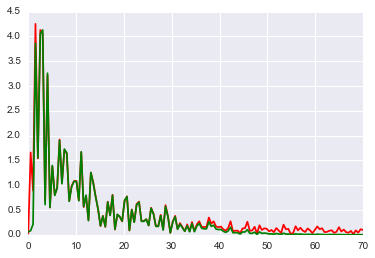

In [82]:
wave = wave[:,:] - np.mean(wave[:,:])
normval = wave.shape[0]
steps = np.linspace(0.0, normval/(fs), normval)
freqs = np.linspace(0.01, 70.0, 140)
pgram = lombscargle(steps, wave[:,1], freqs)
# pgram2 = lombscargle(steps, dat2[:12800] - np.mean(dat2[:12800]), freqs)
pgram2 = lombscargle(steps, wave2[:,1] - np.mean(wave2[:,1]), freqs)
# plt.subplot(3,1,1)
plt.plot(freqs, np.sqrt(4*(pgram/normval)), "r")
# plt.subplot(3,1,2)
plt.plot(freqs, np.sqrt(4*(pgram2/normval)), "g")
# plt.subplot(3,1,3)
# plt.plot(freqs, np.sqrt(4*(pgram3/normval)), "b")

## Motor Noise Removal

In [83]:
filtered = wave2
gyrox = np.asarray(database["GYROX_md"])
gyroy = np.asarray(database["GYROY_md"])
gyroz = np.asarray(database["GYROZ"])

In [84]:
# combine gyro
gyro = np.abs(gyrox - np.mean(gyrox)) + np.abs(gyroy - np.mean(gyroy)) + np.abs(gyroz - np.mean(gyroz))

In [85]:
# stats
# minimum = min(filtered)
# maximum = max(filtered)
print(filtered.shape)
mean = np.mean(filtered, axis=0)
stdev = np.std(filtered, axis=0, dtype="float64")
print(mean)
print(stdev)
start = 0
end = 170000

# gyro stats
gyro_min = min(gyro)
gyro_max = max(gyro)
gyro_mean = np.mean(gyro)
gyro_stdev = np.std(gyro, dtype="float64")

(209407, 14)
[ 0.01428897  0.02429281  0.00978216  0.00429317  0.01154931  0.00106831
  0.00149466 -0.00355578 -0.00124174 -0.00123958 -0.02324366  0.00206407
  0.00373467  0.01046337]
[ 145.76293582   75.27986331   43.07370464   36.63692165   67.21441409
   36.39515435   97.93826971   61.15261773   39.8225744    39.29888982
   77.34211454   37.288973     71.7191222    87.61080642]


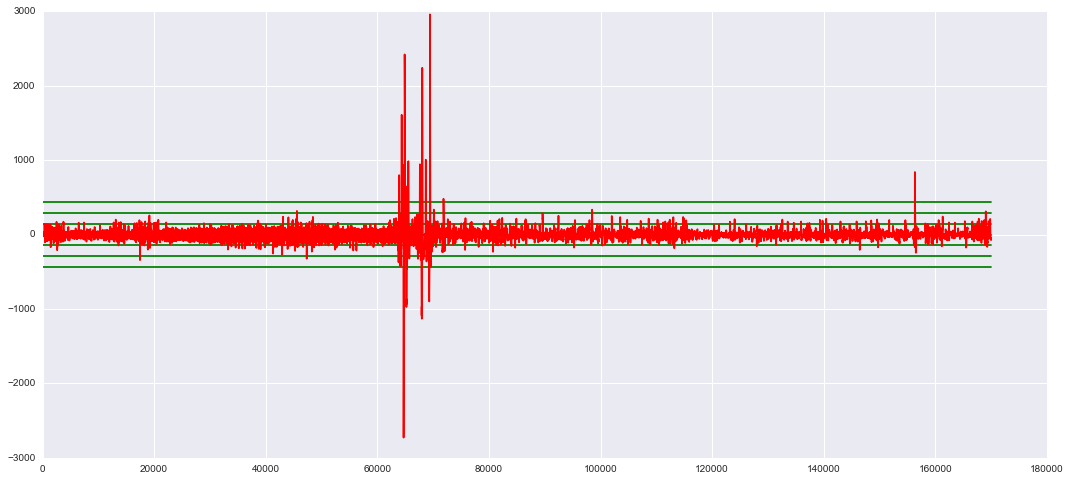

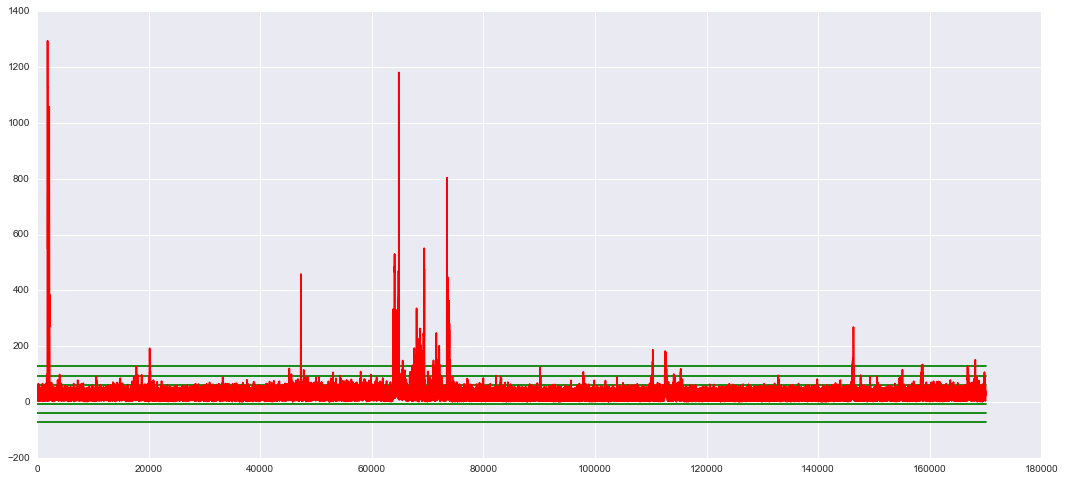

In [86]:
# visualization
def visualize_range(wave, mean, stdev, start, end):
    xrange = len(wave[start:end])
    plt.figure(figsize=[18, 8])
    plt.plot([0, xrange],[mean, mean], 'b')
    plt.plot([0, xrange], [mean+stdev, mean+stdev], 'g')
    plt.plot([0, xrange], [mean-stdev, mean-stdev], 'g')
    plt.plot([0, xrange], [mean+2*stdev, mean+2*stdev], 'g')
    plt.plot([0, xrange], [mean-2*stdev, mean-2*stdev], 'g')
    plt.plot([0, xrange], [mean+3*stdev, mean+3*stdev], 'g')
    plt.plot([0, xrange], [mean-3*stdev, mean-3*stdev], 'g')
    plt.plot(wave[start:end], 'r')
    
visualize_range(filtered[:,0], mean[0], stdev[0], start, end)
visualize_range(gyro, gyro_mean, gyro_stdev, start, end)

(209407, 14)


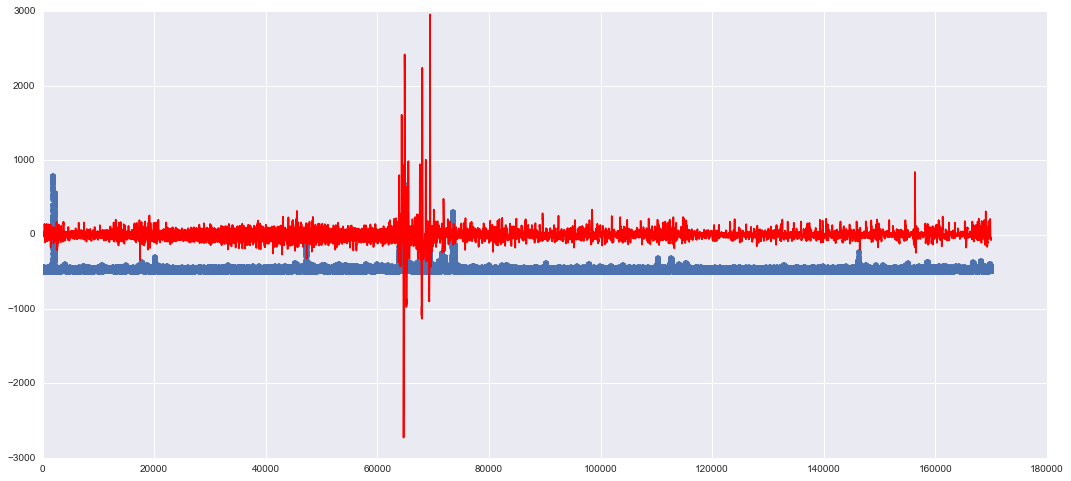

In [87]:
plt.figure(figsize=[18, 8])
plt.plot(gyro[start:end] - 500, 'p')
plt.plot(filtered[start:end,0], 'r')
print(filtered.shape)

In [88]:
def filter_with_gyro(wave, gyro, blur_size):
    
    wave2 = np.copy(wave)
    # stats
    mean = np.mean(wave2, axis=0)
    stdev = np.std(wave2, axis=0, dtype="float64")
    gyro_mean = np.mean(gyro)
    gyro_stdev = np.std(gyro, dtype="float64")
    print(len(gyro))
    
    # create mask based on gyro data
    mask = gyro - 2.0 * gyro_stdev - gyro_mean
    mask[mask > 0] = 0.0
    mask[mask < 0] = 1.0
    print(sum(mask))
    
    # create mask based on outliers
    mask2 = np.abs(wave2) - 4.0 * stdev - mean
    mask2[mask2 > 0] = 0.0
    mask2[mask2 < 0] = 1.0
    
    # merge masks
    mask2 = np.prod(mask2, axis=1)
    print(sum(mask2))
    mask = mask * mask2
    print(sum(mask))
    
    # blur mask to filter out peaks
    box_filter = np.ones([blur_size,]) / blur_size
    mask = np.convolve(mask, box_filter, 'same')
    mask[mask < 1.0] = 0.0
    
    # get the mask indices by first and last index of region to remove
    indices = np.where(mask == 0.0)[0]
    indices = np.split(indices, np.where(np.diff(indices) != 1)[0]+1)
    indices = [[i[0], i[-1]] for i in indices]
    print("percentage data retained: ", sum(mask)/len(mask))
    print(indices)
    
    
    # apply mask to data
    for chunk in indices:
        chk_mean = (wave[chunk[0]] + wave[chunk[1]]) / 2
        wave2[chunk[0]:chunk[1]] = chk_mean
    
    
    return wave2, mask
    
filtered2, mask = filter_with_gyro(filtered, gyro, 150)

209407
206647.0
202893.0
201087.0
percentage data retained:  0.861150773374
[[0, 74], [977, 1137], [1334, 1536], [1694, 2348], [2404, 2737], [3292, 3641], [3661, 3884], [3988, 4138], [6399, 6552], [13588, 13767], [13935, 14085], [14673, 14874], [17743, 17911], [17953, 18103], [18685, 18835], [20095, 20397], [25287, 25439], [26012, 26194], [29945, 30105], [35341, 35508], [35681, 35928], [36146, 36369], [40836, 41051], [41206, 41374], [45125, 45301], [45525, 45675], [47197, 47407], [47735, 47889], [48967, 49185], [49909, 50117], [52692, 52858], [52991, 53145], [54772, 54972], [57337, 57496], [57941, 58095], [58683, 58833], [59581, 59736], [59779, 59931], [60851, 61034], [61586, 61760], [63622, 66022], [66393, 67423], [67433, 68323], [68434, 68948], [69083, 69645], [69740, 70252], [70291, 70650], [70953, 71173], [71441, 71755], [71783, 72393], [72549, 72705], [72928, 73088], [73373, 74061], [82207, 82357], [90087, 90243], [97841, 97995], [110205, 110453], [111523, 111676], [112443, 112941

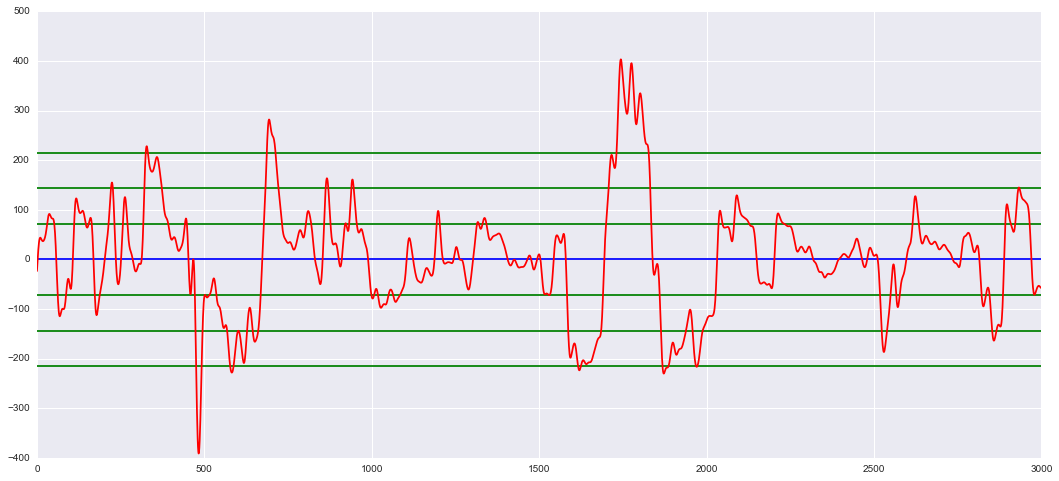

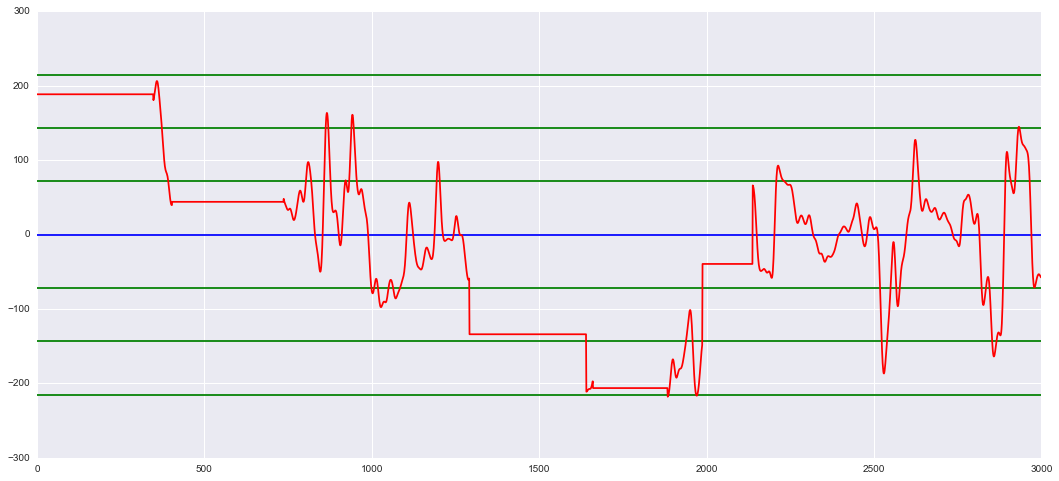

In [89]:
visualize_range(filtered[:,12], 0.0, stdev[12], 2000, 5000)
visualize_range(filtered2[:,12], 0.0, stdev[12], 2000, 5000)

## ICA

In [90]:
# Do a 66/34 split of training and test. Play a bit with this to get nice sized training and test sets.
x_train = filtered2[mask>0]
x_train2 = filtered


# x_test = data.loc[n_train:, ' AF3':' AF4'].values

x_train.shape, type(x_train)

# shift = min(np.amin(x_train), np.amin(x_test))
# normalize = max(np.amax(x_train), np.amax(x_test)) - shift

# x_train = (x_train.astype('float32') - shift) / normalize
# x_test = (x_test.astype('float32') - shift) / normalize

((180331, 14), numpy.ndarray)

In [91]:
ica = FastICA(n_components = 14, max_iter=10000, whiten=True)
S = ica.fit_transform(x_train)  # Reconstruct signals
A = ica.mixing_

ica2 = FastICA(n_components = 14, max_iter=10000, whiten=True)
S2 = ica2.fit_transform(x_train2)
A2 = ica2.mixing_

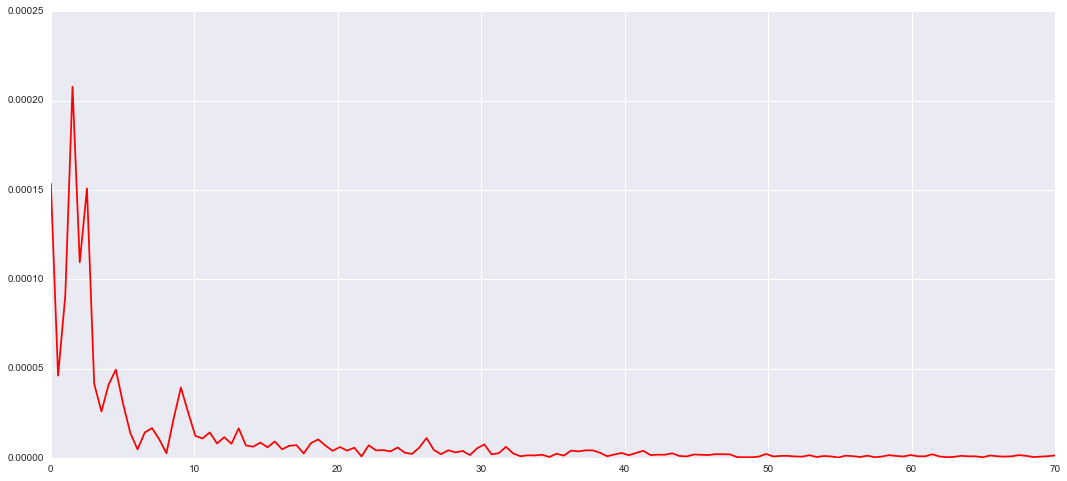

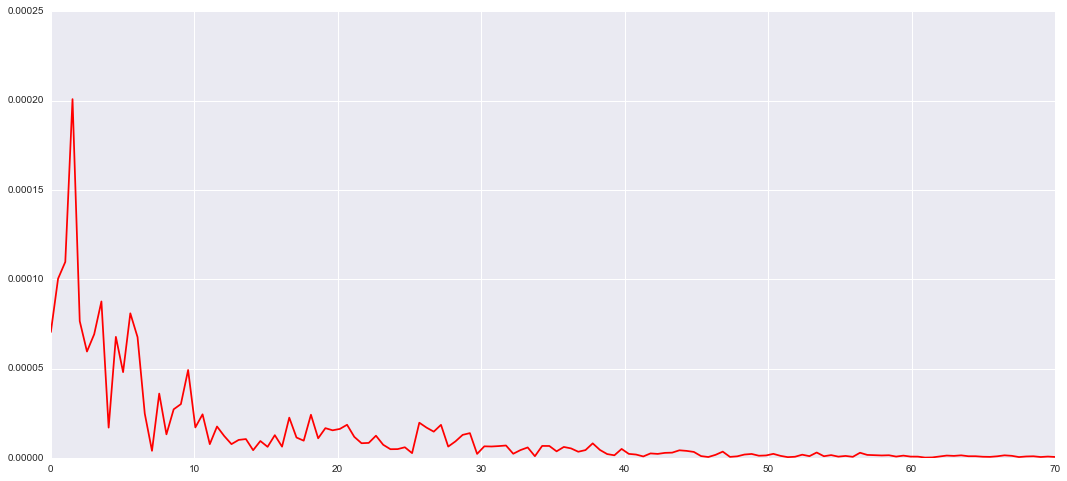

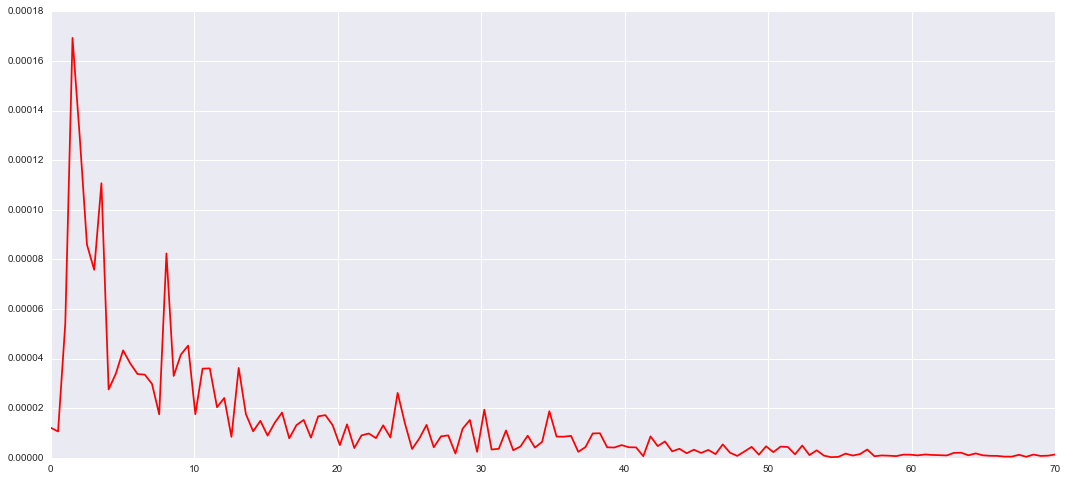

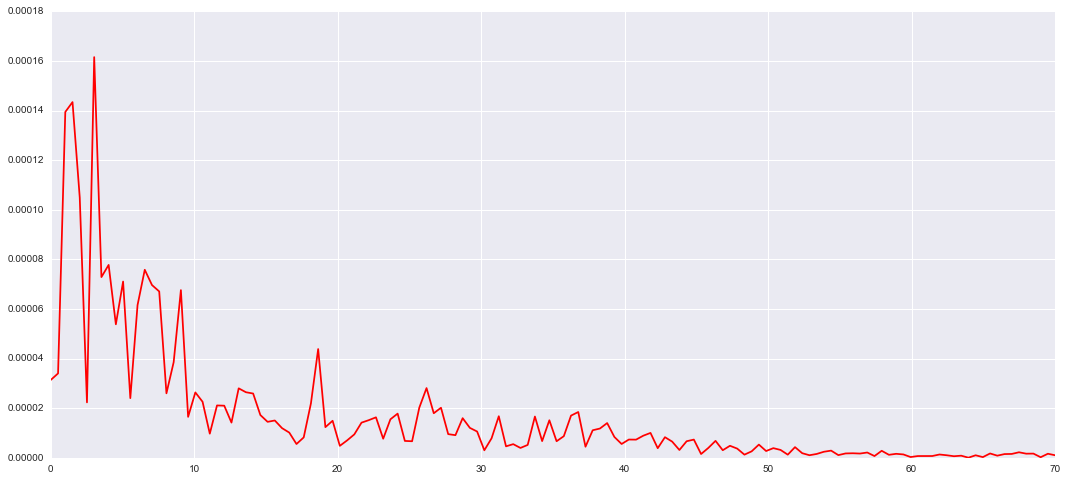

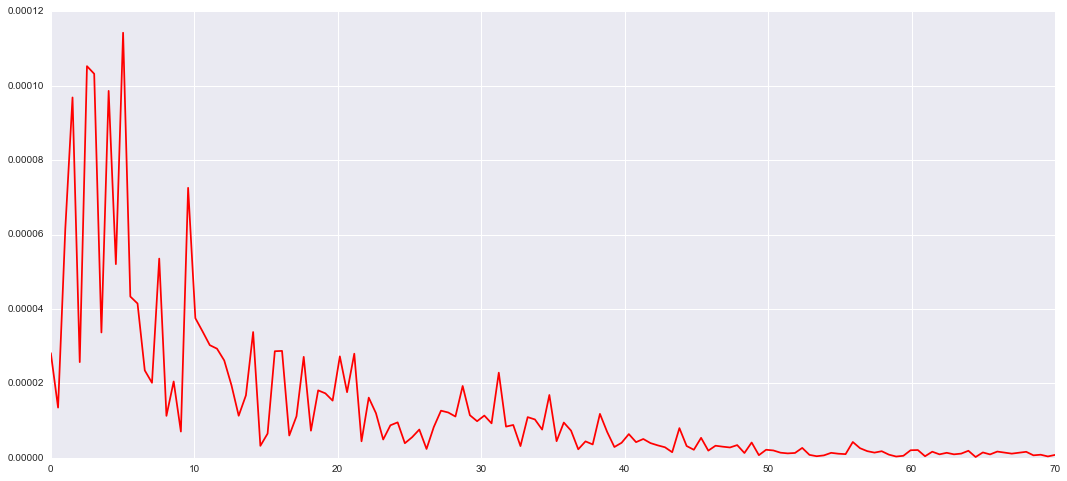

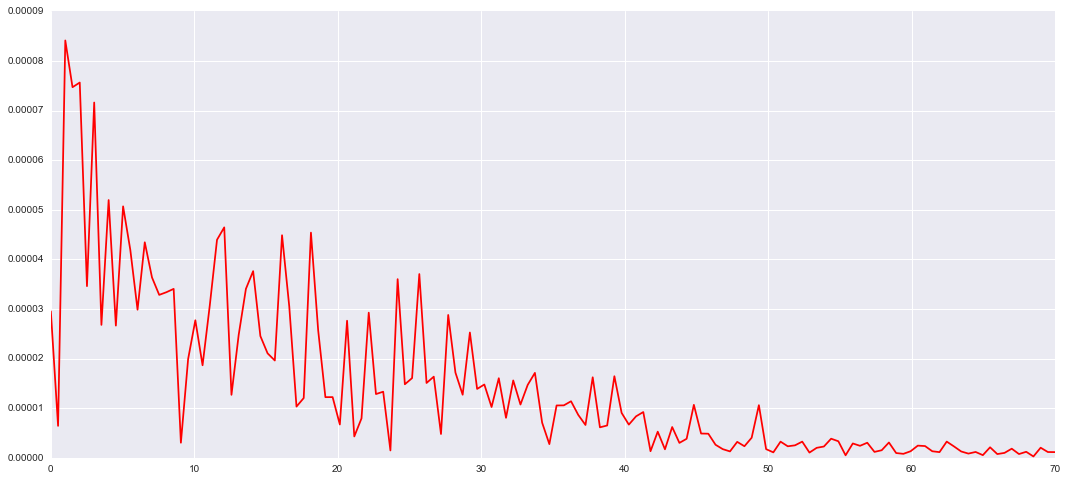

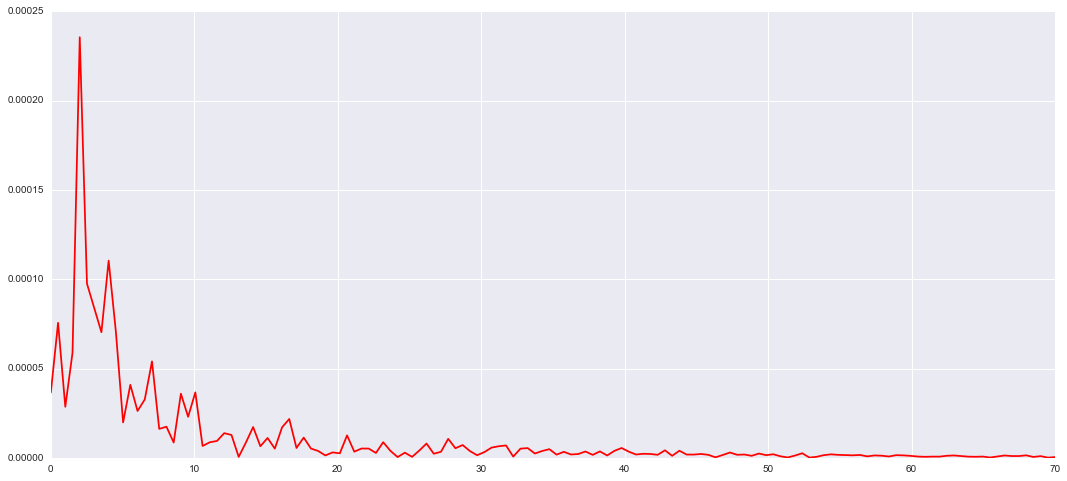

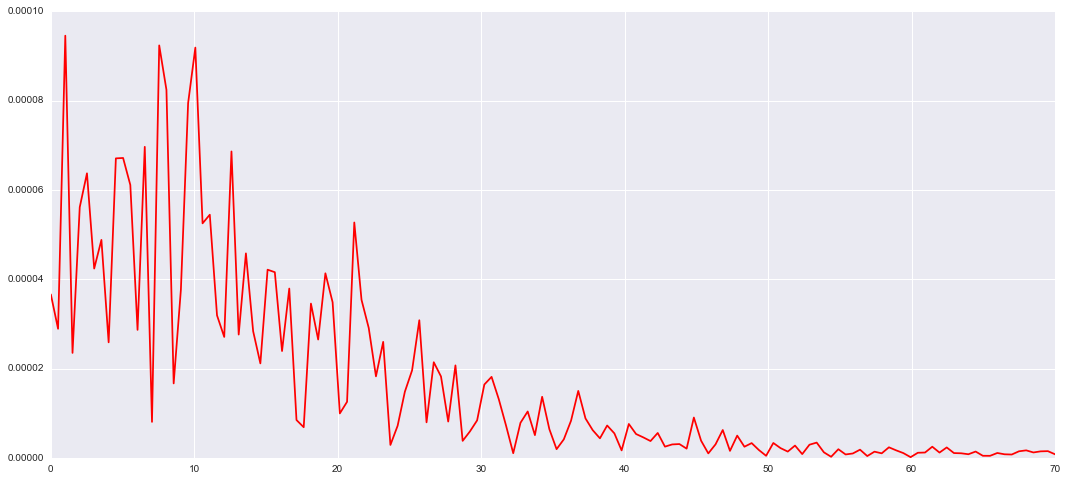

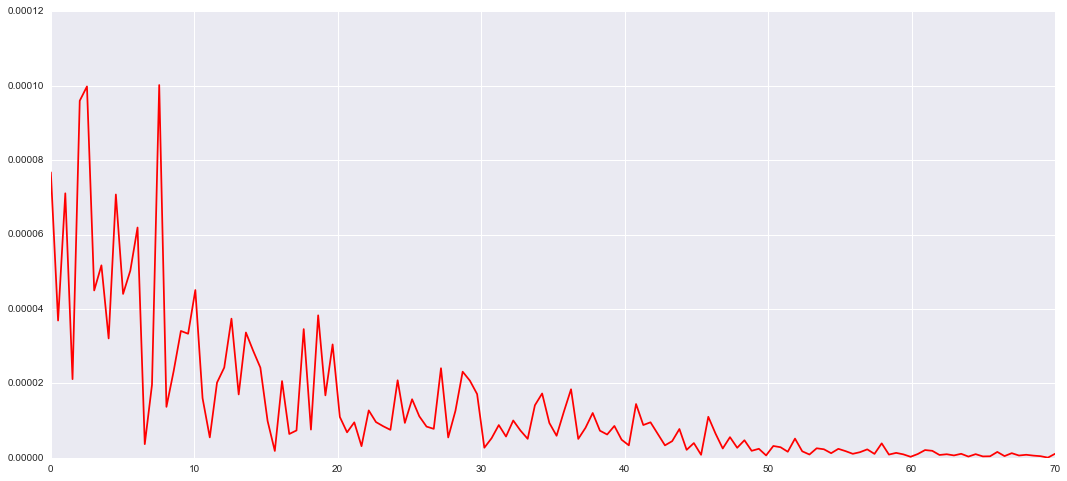

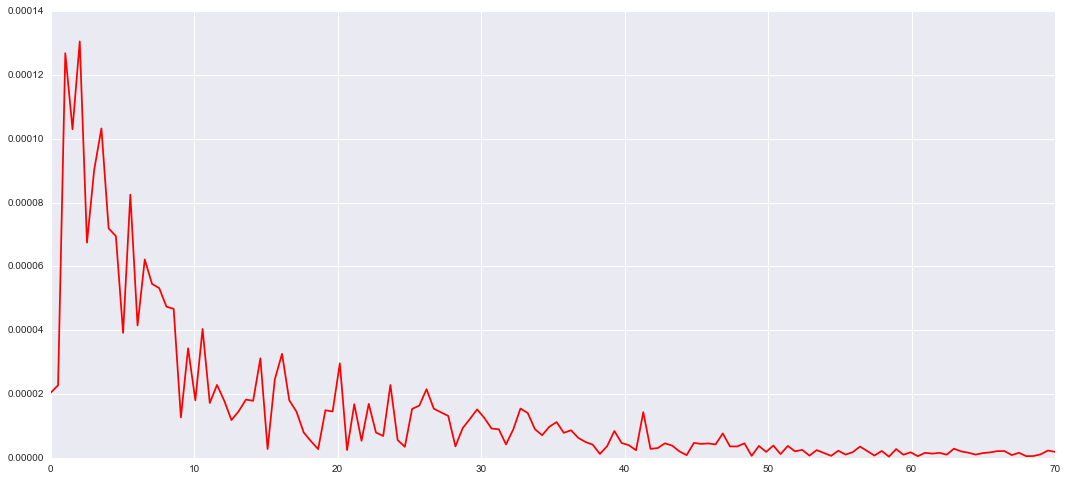

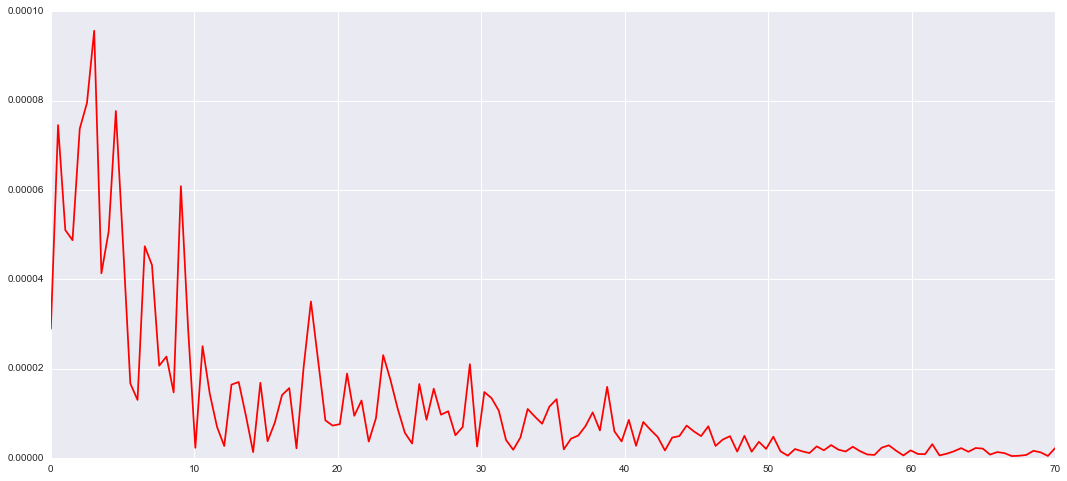

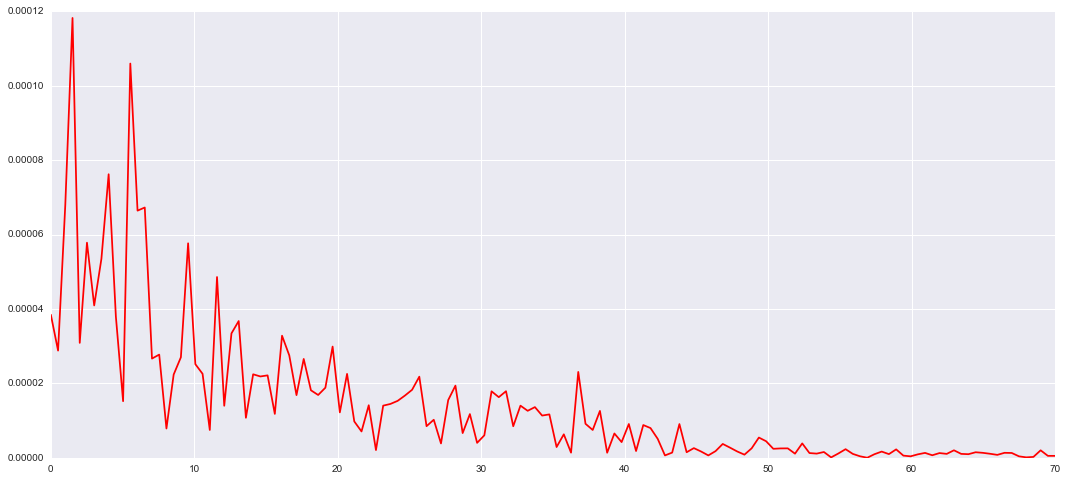

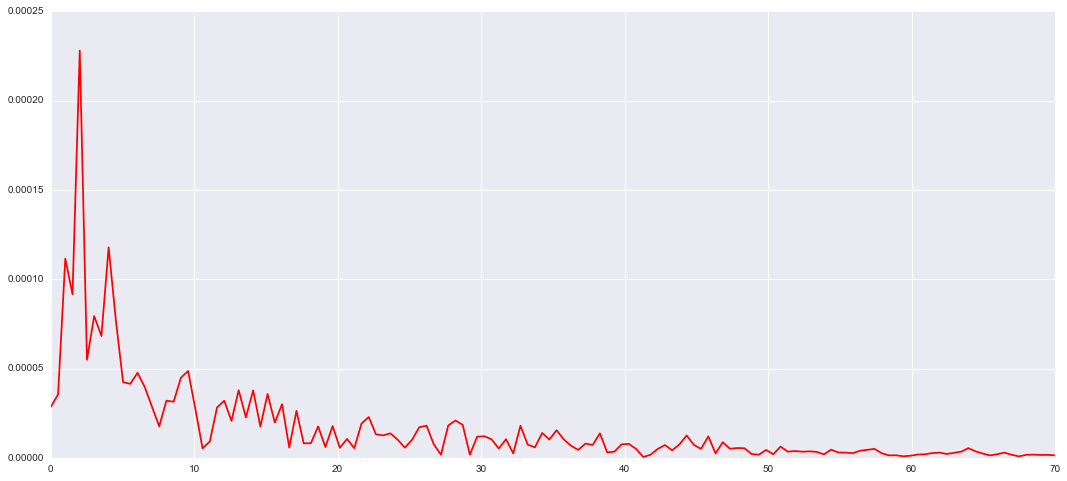

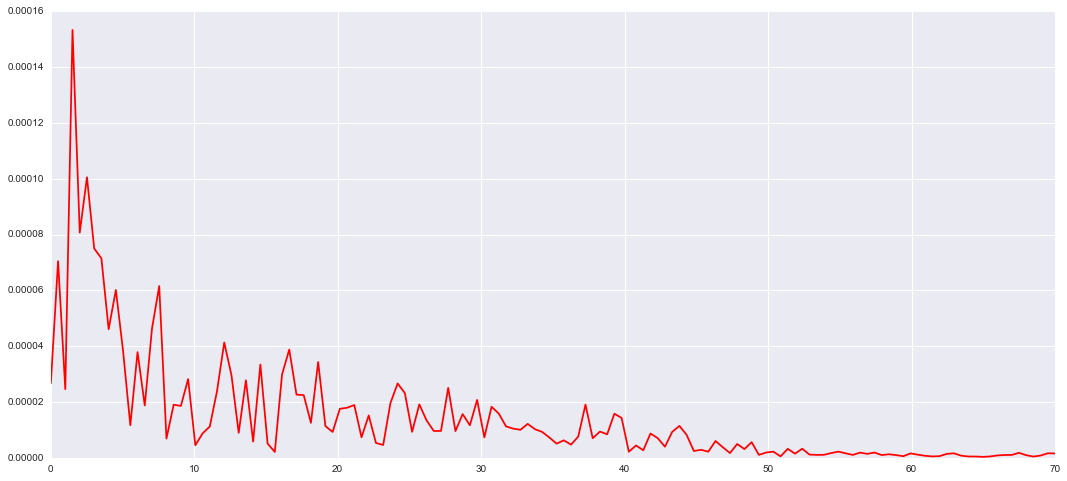

In [136]:
S = S[:,:] - np.mean(S[:,:])
normval = S.shape[0]
steps = np.linspace(0.0, normval/(fs), normval)
freqs = np.linspace(0.01, 70.0, 140)
for i in range(14):
    pgram = lombscargle(steps, S[:,i], freqs)
# pgram2 = lombscargle(steps, dat2[:12800] - np.mean(dat2[:12800]), freqs)
# pgram2 = lombscargle(steps, wave2[:,1] - np.mean(wave2[:,1]), freqs)
# plt.subplot(3,1,1)
    plt.figure(figsize=[18,8])
    plt.plot(freqs, np.sqrt(4*(pgram/normval)), "r")
# plt.subplot(3,1,2)
# plt.plot(freqs, np.sqrt(4*(pgram2/normval)), "g")
# plt.subplot(3,1,3)
# plt.plot(freqs, np.sqrt(4*(pgram3/normval)), "b")

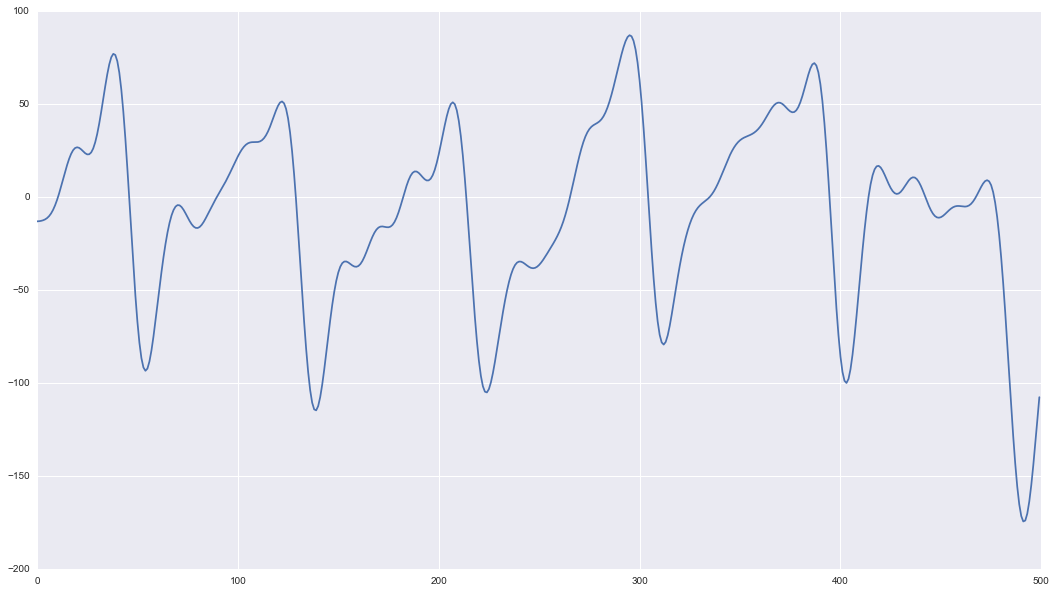

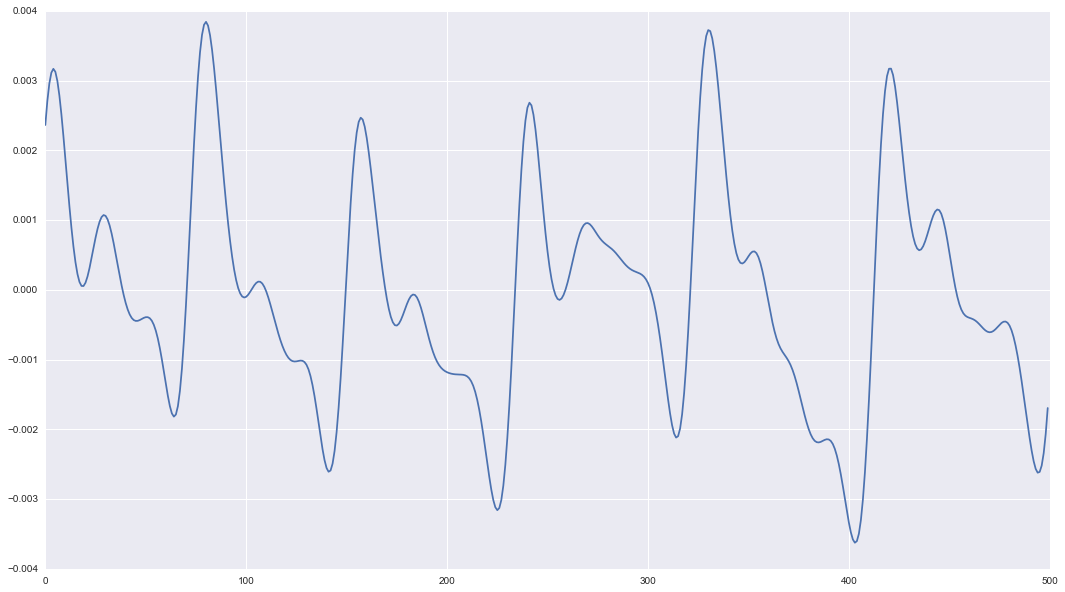

In [147]:
plt.figure(figsize=[18,10])
plt.plot(x_train[30000:30500,0]) #4
# plt.plot(x_train2[2000:5000,12])
plt.figure(figsize=[18,10])
plt.plot(S[20000:20500,1]) #9

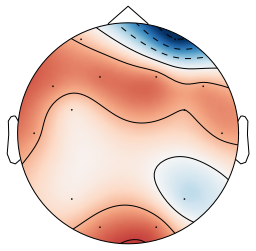

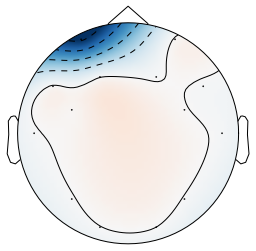

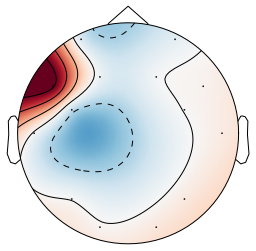

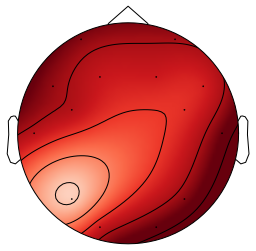

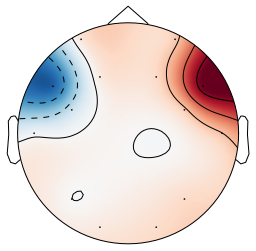

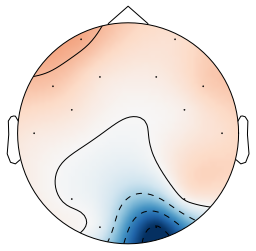

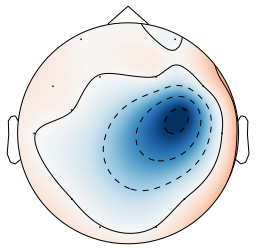

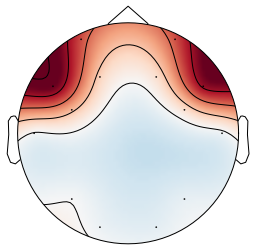

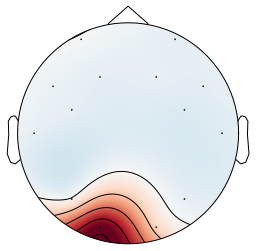

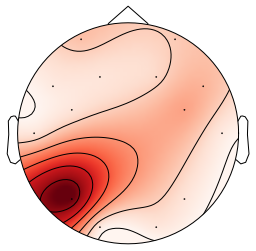

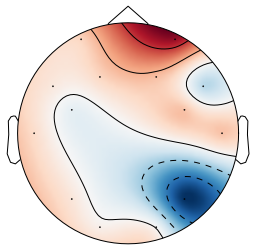

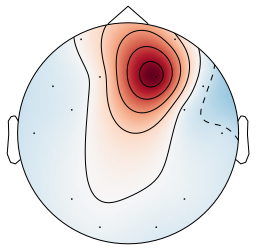

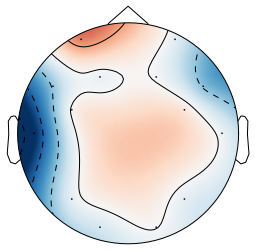

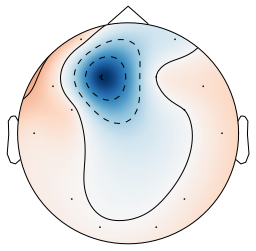

In [113]:
loc = np.array([[-0.5,1.0],[-0.8,0.5],[-0.3,0.6],[-0.6,0.25],[-1.0,0.0],[-0.6,-0.7],[-0.3,-1.0],[0.3,-1.0],[0.6,-0.7],[1.0,0.0],[0.6,0.25],[0.3,0.6],[0.8,0.5],[0.5,1.0]])
for i in range(14):
    plot_topomap(A[:,i], loc)
# plot_topomap(A2[:,i], loc)
# print(A)
# print(S[0:10])

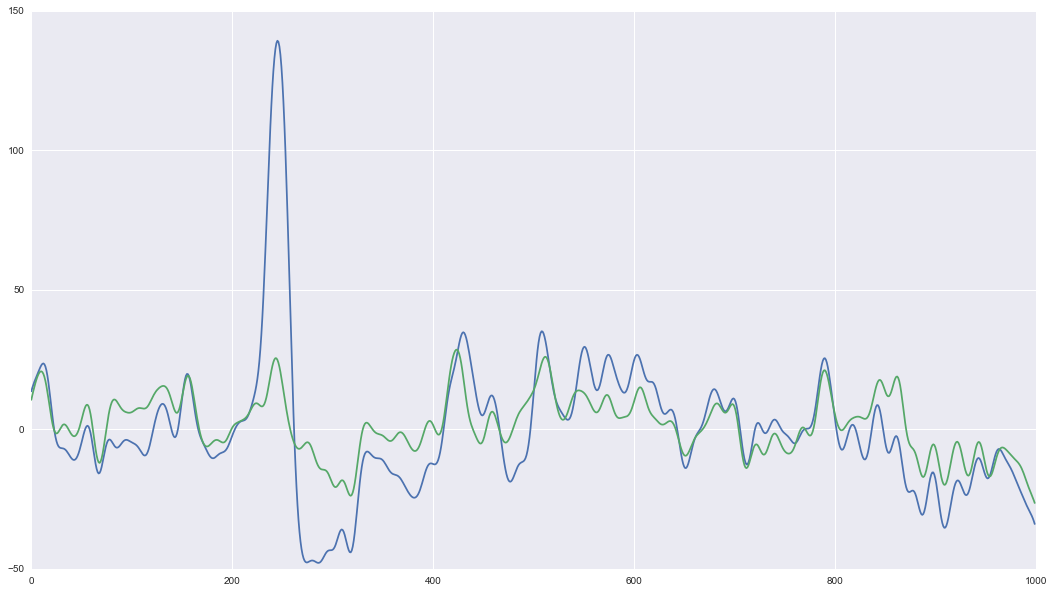

In [149]:
A_new = np.copy(A)
A_new[:, 4] = 0
A_new[:, 7] = 0
A_new[:, 1] = 0
xtrain_new = (np.dot(A_new, S.T)).T
 #4
plt.figure(figsize=[18,10])
plt.plot(x_train[20000:21000,13])
plt.plot(xtrain_new[20000:21000,13]) #4

## Wave visualization

In [7]:
def wave_visualization(wave, mi = 3500, ma = 4800, n = 10**3, start = 0):
    vector = wave[start:]
    i = 1
    while len(vector > n):
        plt.figure(figsize=[18, 8], )
        plt.plot(vector[:n])
        plt.ylim((mi, ma))
        plt.title(str(i*n - n + start) + ' to ' + str(i*n + start)) 
        i += 1
        vector = vector[n:]
        plt.show()
        time.sleep(0.05)
        raw_input("Press Enter to continue")
        clear_output(wait=True)
    plt.plot(vector)

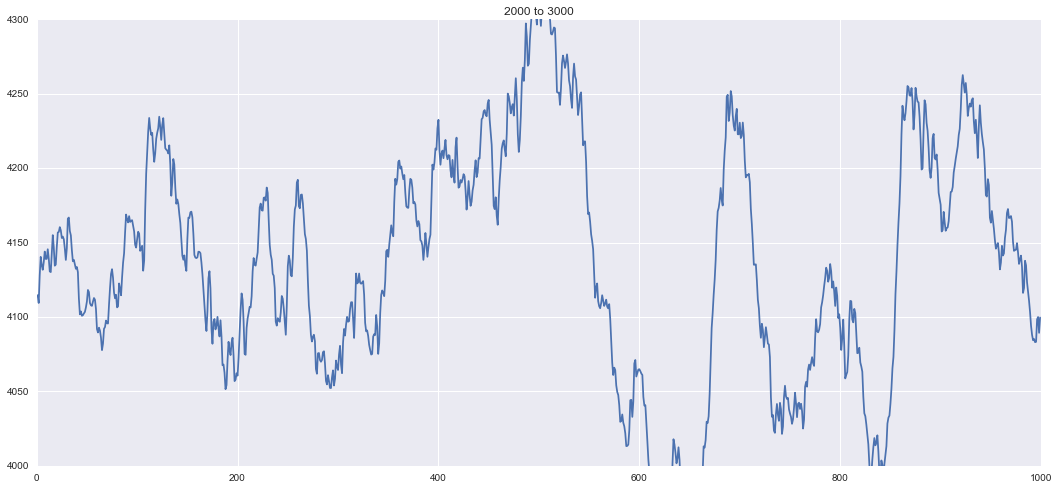

AttributeError: 'list' object has no attribute 'sleep'

In [54]:
wave_visualization(dat2, mi = 4000, ma = 4300, start = 2000)